In [1]:
import torch
import math
import numpy as np
from torch import nn
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Data:
    mu = 4
    sigma = 1.25

    def get_distribution_sampler(self):
        return lambda n: torch.Tensor(np.random.normal(self.mu, self.sigma, (1, n)))  # Gaussian

    def get_generator_input_sampler(self):
        return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [3]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

In [4]:
class Experiment:

    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 4    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = 500

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    def __init__(self):
        self.data = Data()


        self.G = Generator(input_size=self.g_input_size,
                    hidden_size=self.g_hidden_size,
                    output_size=self.g_output_size,
                    f=self.generator_activation_function)
        self.D = Discriminator(input_size=self.d_input_size,
                        hidden_size=self.d_hidden_size,
                        output_size=self.d_output_size,
                        f=self.discriminator_activation_function)
        self.criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
        self.d_optimizer = torch.optim.SGD(self.D.parameters(), lr=self.d_learning_rate, momentum=self.sgd_momentum)
        self.g_optimizer = torch.optim.SGD(self.G.parameters(), lr=self.g_learning_rate, momentum=self.sgd_momentum)

    def preprocess(self, data):
        # Return the first 4 moments of the data provided
        mean = torch.mean(data)
        diffs = data - mean
        var = torch.mean(torch.pow(diffs, 2.0))
        std = torch.pow(var, 0.5)
        zscores = diffs / std
        skews = torch.mean(torch.pow(zscores, 3.0))
        kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
        final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
        return final

    def extract(self, v):
        return v.data.storage().tolist()
        
    def stats(self, d):
        return [np.mean(d), np.std(d)]
        
    def run(self):

        num_epochs = 5000
        print_interval = 100
        d_steps = 20
        g_steps = 20

        dfe, dre, ge = 0, 0, 0
        d_real_data, d_fake_data, g_fake_data = None, None, None


        d_sampler = self.data.get_distribution_sampler()
        gi_sampler = self.data.get_generator_input_sampler()
        

        for epoch in tqdm(range(num_epochs), "Training"):
            for d_index in range(d_steps):
                # 1. Train D on real+fake
                self.d_optimizer.zero_grad()

                #  1A: Train D on real
                d_real_data = d_sampler(self.d_input_size)
                d_real_decision = self.D(self.preprocess(d_real_data))
                d_real_error = self.criterion(d_real_decision, torch.ones([1,1]))  # ones = true
                d_real_error.backward() # compute/store gradients, but don't change params

                #  1B: Train D on fake
                d_gen_input = gi_sampler(self.minibatch_size, self.g_input_size)
                d_fake_data = self.G(d_gen_input).detach()  # detach to avoid training G on these labels
                d_fake_decision = self.D(self.preprocess(d_fake_data.t()))
                d_fake_error = self.criterion(d_fake_decision, torch.zeros([1,1]))  # zeros = fake
                d_fake_error.backward()
                self.d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

                dre, dfe = self.extract(d_real_error)[0], self.extract(d_fake_error)[0]

            for g_index in range(g_steps):
                # 2. Train G on D's response (but DO NOT train D on these labels)
                self.g_optimizer.zero_grad()

                gen_input = gi_sampler(self.minibatch_size, self.g_input_size)
                g_fake_data = self.G(gen_input)
                dg_fake_decision = self.D(self.preprocess(g_fake_data.t()))
                g_error = self.criterion(dg_fake_decision, torch.ones([1,1]))  # Train G to pretend it's genuine

                g_error.backward()
                self.g_optimizer.step()  # Only optimizes G's parameters
                ge = self.extract(g_error)[0]

            if epoch % print_interval == 0:
                log = "\nEpoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " % (epoch, dre, dfe, ge, self.stats(self.extract(d_real_data)), self.stats(self.extract(d_fake_data)))
                tqdm.write(log)

        print("Plotting the generated distribution...")
        values = self.extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()

3<03:52, 16.32it/s]
Epoch 1200: D (0.6983749866485596 real_err, 0.6924543380737305 fake_err) G (0.693490207195282 err); Real Dist ([3.9460214376449585, 0.7546856538082067]),  Fake Dist ([3.8912202706336974, 0.9071847850931224]) 
Training:  26%|██▌       | 1303/5000 [01:29<04:04, 15.12it/s]
Epoch 1300: D (0.6920298337936401 real_err, 0.6928467154502869 fake_err) G (0.6940016746520996 err); Real Dist ([4.00313013792038, 0.5851111300555213]),  Fake Dist ([4.001368626594544, 0.9041149615916563]) 
Training:  28%|██▊       | 1403/5000 [01:35<03:17, 18.23it/s]
Epoch 1400: D (0.6905322670936584 real_err, 0.6923202276229858 fake_err) G (0.693969190120697 err); Real Dist ([2.9573178440332413, 1.531573593189226]),  Fake Dist ([3.9769635195732116, 0.9011165862685907]) 
Training:  30%|███       | 1503/5000 [01:41<03:16, 17.76it/s]
Epoch 1500: D (0.6938406229019165 real_err, 0.6927235722541809 fake_err) G (0.6937630772590637 err); Real Dist ([4.7673274874687195, 1.9002897336782654]),  Fake Dist ([3.

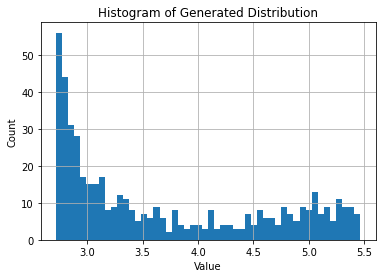

In [5]:
Experiment().run()

t ([4.3395020961761475, 0.18600863776484527]),  Fake Dist ([3.799012387752533, 0.729586911657243]) 
Training:  24%|██▍       | 1203/5000 [01:15<03:26, 18.35it/s]
Epoch 1200: D (0.6934971213340759 real_err, 0.6962994933128357 fake_err) G (0.6902835965156555 err); Real Dist ([5.0509427189826965, 1.3697845962838788]),  Fake Dist ([3.6933686311244966, 1.477287392201925]) 
Training:  26%|██▌       | 1303/5000 [01:25<04:41, 13.11it/s]
Epoch 1300: D (0.683624804019928 real_err, 0.6903791427612305 fake_err) G (0.6946063041687012 err); Real Dist ([4.015702307224274, 0.5639642328995864]),  Fake Dist ([3.5345152366161345, 1.7237290460203487]) 
Training:  28%|██▊       | 1404/5000 [01:37<03:12, 18.66it/s]
Epoch 1400: D (0.7014652490615845 real_err, 0.6931302547454834 fake_err) G (0.693817138671875 err); Real Dist ([3.971009850502014, 1.3985792485111606]),  Fake Dist ([4.253096612453461, 0.8605065571981422]) 
Training:  30%|███       | 1504/5000 [01:42<03:10, 18.37it/s]
Epoch 1500: D (0.70206153392

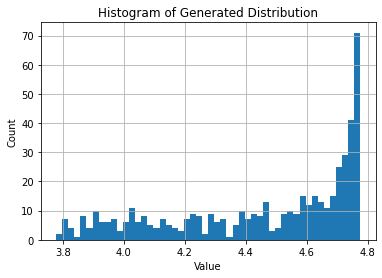

In [6]:
Experiment().run()

   | 1204/5000 [01:04<03:42, 17.06it/s]
Epoch 1200: D (0.6990194320678711 real_err, 0.6907557249069214 fake_err) G (0.6934694647789001 err); Real Dist ([4.734843611717224, 0.4833774617852277]),  Fake Dist ([3.468695725440979, 1.021015208567755]) 
Training:  26%|██▌       | 1304/5000 [01:10<03:21, 18.36it/s]
Epoch 1300: D (0.6686834692955017 real_err, 0.7011350393295288 fake_err) G (0.6800292730331421 err); Real Dist ([4.2669717669487, 1.5118986050105239]),  Fake Dist ([3.7527989320755006, 0.8058059604607326]) 
Training:  28%|██▊       | 1402/5000 [01:15<03:12, 18.69it/s]
Epoch 1400: D (0.7241418957710266 real_err, 0.6797605752944946 fake_err) G (0.7055930495262146 err); Real Dist ([5.0783661007881165, 1.2506765511128042]),  Fake Dist ([6.001117680549622, 1.0079782291820194]) 
Training:  30%|███       | 1504/5000 [01:21<03:15, 17.89it/s]
Epoch 1500: D (0.6985686421394348 real_err, 0.6983417272567749 fake_err) G (0.6882111430168152 err); Real Dist ([3.5475509762763977, 1.4639630762376499

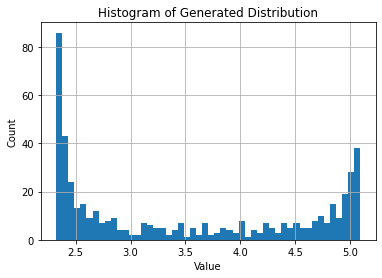

In [7]:
Experiment().run()

ng:  24%|██▍       | 1203/5000 [01:05<03:25, 18.44it/s]
Epoch 1200: D (0.6919715404510498 real_err, 0.6921494007110596 fake_err) G (0.6936205625534058 err); Real Dist ([4.041469395160675, 1.3360960554908785]),  Fake Dist ([3.864877074241638, 1.0352999948751473]) 
Training:  26%|██▌       | 1303/5000 [01:11<03:43, 16.56it/s]
Epoch 1300: D (0.699379026889801 real_err, 0.691650927066803 fake_err) G (0.6942359209060669 err); Real Dist ([4.059554934501648, 1.758565429199308]),  Fake Dist ([3.7761290969848633, 0.9401743766590459]) 
Training:  28%|██▊       | 1403/5000 [01:16<03:09, 18.97it/s]
Epoch 1400: D (0.6960818767547607 real_err, 0.691490113735199 fake_err) G (0.6922672986984253 err); Real Dist ([3.757956862449646, 0.5256544329984146]),  Fake Dist ([4.198757409572601, 0.8227374631458384]) 
Training:  30%|███       | 1504/5000 [01:22<03:16, 17.83it/s]
Epoch 1500: D (0.6977158188819885 real_err, 0.6938388347625732 fake_err) G (0.693852424621582 err); Real Dist ([3.119984745979309, 0.5527

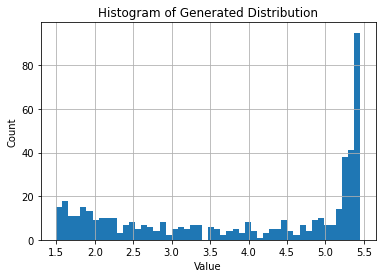

In [8]:
Experiment().run()

07748781383]) 
Training:  24%|██▍       | 1205/5000 [01:06<03:23, 18.64it/s]
Epoch 1200: D (0.6986881494522095 real_err, 0.7044607400894165 fake_err) G (0.6875717043876648 err); Real Dist ([4.802846908569336, 1.4912138036799112]),  Fake Dist ([3.702410012960434, 0.8488612497003012]) 
Training:  26%|██▌       | 1303/5000 [01:11<03:38, 16.94it/s]
Epoch 1300: D (0.6907035112380981 real_err, 0.6945406198501587 fake_err) G (0.6912838816642761 err); Real Dist ([4.934830904006958, 0.683218541475935]),  Fake Dist ([3.672223809480667, 1.3435091708984817]) 
Training:  28%|██▊       | 1404/5000 [01:17<03:36, 16.57it/s]
Epoch 1400: D (0.6772506833076477 real_err, 0.6771496534347534 fake_err) G (0.7075241804122925 err); Real Dist ([3.7165563106536865, 0.5913031898661558]),  Fake Dist ([4.38405969452858, 1.2874231574468094]) 
Training:  30%|███       | 1504/5000 [01:22<03:12, 18.14it/s]
Epoch 1500: D (0.7077957987785339 real_err, 0.703967273235321 fake_err) G (0.6821849346160889 err); Real Dist ([3.

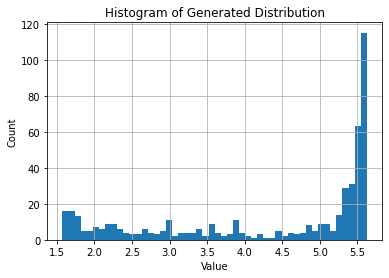

In [9]:
Experiment().run()

,  Fake Dist ([3.920425748348236, 0.5910934886213834]) 
Training:  24%|██▍       | 1203/5000 [01:05<03:24, 18.53it/s]
Epoch 1200: D (0.691968560218811 real_err, 0.6918888688087463 fake_err) G (0.6944878697395325 err); Real Dist ([4.384663224220276, 1.106101885089666]),  Fake Dist ([3.8696850981712343, 0.8231112260323747]) 
Training:  26%|██▌       | 1304/5000 [01:10<03:10, 19.40it/s]
Epoch 1300: D (0.6878525018692017 real_err, 0.6945260763168335 fake_err) G (0.6916733980178833 err); Real Dist ([4.244124472141266, 1.7019281110515376]),  Fake Dist ([3.8648059267997743, 1.1729727114620625]) 
Training:  28%|██▊       | 1404/5000 [01:15<03:15, 18.36it/s]
Epoch 1400: D (0.6947230696678162 real_err, 0.6911632418632507 fake_err) G (0.6950750946998596 err); Real Dist ([3.4040200412273407, 0.9415315620088931]),  Fake Dist ([4.129089458942413, 1.269997478283858]) 
Training:  30%|███       | 1503/5000 [01:20<03:05, 18.83it/s]
Epoch 1500: D (0.6934359073638916 real_err, 0.6919251084327698 fake_err)

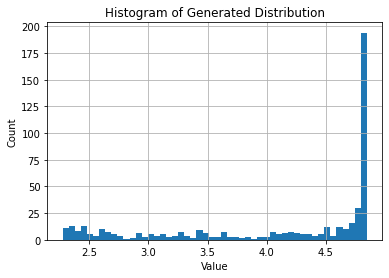

In [10]:
Experiment().run()